# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [3]:
useColab=True
if useColab:
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/requirements.txt
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/muestras_voz.zip      
    !pip install -r requirements.txt
    !unzip muestras_voz.zip

Archive:  muestras_voz.zip
   creating: muestras_voz/
   creating: muestras_voz/test/
   creating: muestras_voz/test/background/
  inflating: muestras_voz/test/background/0_2019-06-06-09h57m31s.wav.npy  
  inflating: muestras_voz/test/background/0_2019-06-06-09h57m36s.wav.npy  
  inflating: muestras_voz/test/background/0_2019-06-06-09h57m41s.wav.npy  
   creating: muestras_voz/test/cero/
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m36s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m42s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m48s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m54s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h51m06s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m20s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m27s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m33s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m40

In [4]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

Using TensorFlow backend.


Añadimos google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=1, task = '10digit')

Done preparing Google Speech commands dataset version 1


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [35]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
217
11


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [29]:
sr=16000 #we know this one for google audios
iLen = 48000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

2

In [36]:
audios, classes = valGen.__getitem__(1)
classes

array([ 9,  8,  3,  6,  7,  5,  4,  1,  2,  5,  5,  1, 10,  1,  8,  0,  5,
        8, 10,  3,  3,  5,  4,  1,  4, 10, 10, 10,  6,  4,  6,  9,  7,  5,
        6,  5, 10,  3,  8,  3,  8,  4,  1,  0,  5,  9, 10,  6, 10,  9])

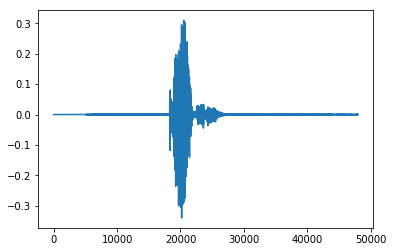

In [37]:
librosa.output.write_wav('file.wav', audios[5], sr, norm=False)
plt.plot(audios[5])

In [38]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

W0619 10:32:15.486438 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 10:32:15.532143 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 10:32:15.652002 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 375, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 375, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [39]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

W0619 10:32:23.924785 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0619 10:32:23.940600 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



(50, 80, 375, 1)

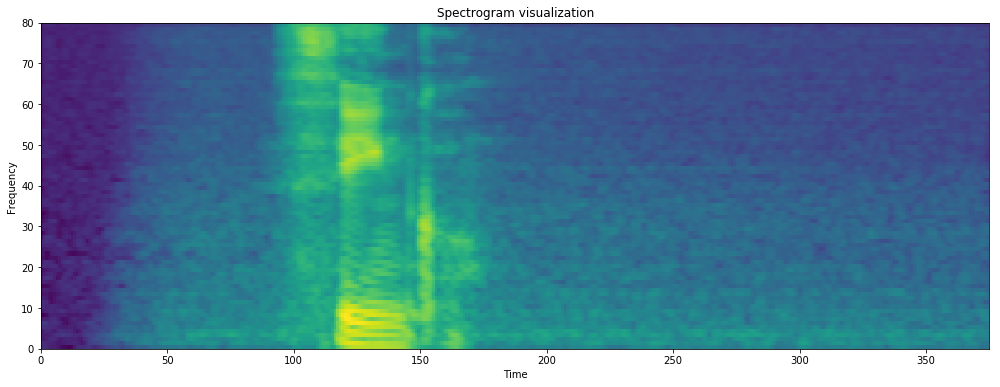

In [40]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[3,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([9.0000e+00, 7.0000e+00, 1.3000e+01, 3.3000e+01, 3.6000e+01,
        6.9000e+01, 1.1900e+02, 1.7700e+02, 3.5900e+02, 5.7100e+02,
        9.6300e+02, 1.2880e+03, 1.6860e+03, 2.6230e+03, 4.7210e+03,
        7.8440e+03, 9.7260e+03, 9.5290e+03, 6.9940e+03, 4.8230e+03,
        4.2170e+03, 6.2720e+03, 1.2961e+04, 2.8895e+04, 5.1700e+04,
        7.5515e+04, 8.5282e+04, 7.8840e+04, 6.6897e+04, 6.0309e+04,
        5.6155e+04, 5.2722e+04, 5.0656e+04, 5.2369e+04, 5.3741e+04,
        5.5546e+04, 5.5921e+04, 5.4852e+04, 5.2052e+04, 4.8763e+04,
        4.3879e+04, 3.8554e+04, 3.3605e+04, 2.8704e+04, 2.5340e+04,
        2.2680e+04, 1.9931e+04, 1.7392e+04, 1.5632e+04, 1.3713e+04,
        1.2674e+04, 1.1740e+04, 1.1063e+04, 1.0505e+04, 9.9810e+03,
        9.4270e+03, 9.2850e+03, 8.8890e+03, 8.7460e+03, 8.2400e+03,
        7.6350e+03, 7.2270e+03, 6.6980e+03, 6.3390e+03, 5.7260e+03,
        5.4620e+03, 4.7840e+03, 4.5910e+03, 4.1660e+03, 3.7460e+03,
        3.5560e+03, 3.2770e+03, 3.0810e+03, 2.81

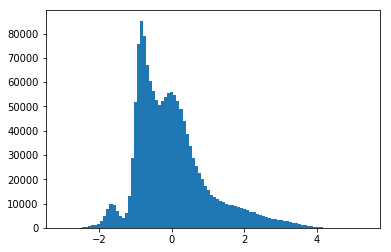

In [41]:
plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [0]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [43]:
#self-attention LSTM
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

W0619 10:32:55.505402 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0619 10:32:57.742425 140247372564352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48000)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 48000)     0           input_1[0][0]                    
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 375, 1)   1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
normalization2d_2 (Normalizatio (None, 80, 375, 1)   0           mel_stft[0][0]                   
__________________________________________________________________________________________________
permute_1 

In [0]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [45]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4,
                    callbacks=[earlystopper, checkpointer, lrate])

W0619 10:33:18.217931 140247372564352 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
Changing learning rate to 0.001
4/4 [==============================] - 4s 1s/step - loss: 2.3670 - sparse_categorical_accuracy: 0.1950 - val_loss: 2.2688 - val_sparse_categorical_accuracy: 0.2500

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.25000, saving model to model-attRNN.h5
Epoch 2/40
Changing learning rate to 0.001
4/4 [==============================] - 1s 344ms/step - loss: 2.1263 - sparse_categorical_accuracy: 0.3450 - val_loss: 2.0259 - val_sparse_categorical_accuracy: 0.2600

Epoch 00002: val_sparse_categorical_accuracy improved from 0.25000 to 0.26000, saving model to model-attRNN.h5
Epoch 3/40
Changing learning rate to 0.001
4/4 [==============================] - 1s 364ms/step - loss: 1.7368 - sparse_categorical_accuracy: 0.4650 - val_loss: 2.0020 - val_sparse_categorical_accuracy: 0.3700

Epoch 00003: val_sparse_categorical_accuracy improved from 0.26000 to 0.37000, saving model to model-attRNN.h5
Epoch 4/40
Changing learning rate to 0.0

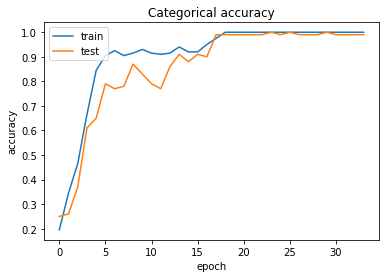

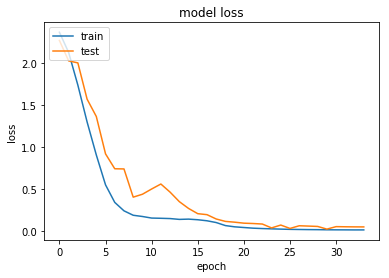

In [46]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
results.history

{'loss': [2.3669947385787964,
  2.1263116002082825,
  1.7368016242980957,
  1.2992274463176727,
  0.9056543856859207,
  0.5496294274926186,
  0.34064216911792755,
  0.24028505012392998,
  0.18753308802843094,
  0.1728569120168686,
  0.15406183525919914,
  0.15148412808775902,
  0.14819993823766708,
  0.13832068257033825,
  0.14150931686162949,
  0.13416745327413082,
  0.12176611088216305,
  0.10069181956350803,
  0.06452340167015791,
  0.04979769606143236,
  0.041704374365508556,
  0.033714428544044495,
  0.02920373436063528,
  0.025668952148407698,
  0.02246117079630494,
  0.019642728846520185,
  0.018170383293181658,
  0.016762976767495275,
  0.01596601167693734,
  0.014565127436071634,
  0.013959030853584409,
  0.013632034650072455,
  0.012980059254914522,
  0.01310801855288446],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.0004,
  0.00016,
  0.0001

In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [52]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

FileNotFoundError: ignored

In [0]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

6835/6835 [==============================] - 9s 1ms/step
Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.0225776804774185, 0.9944000626566416] 
Validation: [0.26706687114992234, 0.9453125] 
Test: [0.29388507845448847, 0.941185076810534]


In [0]:
#only for the Kaggle competition, 12-cmd
x_testR, y_testR = testRGen.__getitem__(0)
testREval = model.evaluate(x_testR, y_testR, verbose=1)
testREval

3081/3081 [==============================] - 4s 1ms/step


[0.27773856560475046, 0.9282700421940928]

In [0]:
testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
testREval

76/76 [==============================] - 5s 66ms/step


[0.37633738776170694, 0.9420230263157895]

In [0]:
# Evaluation and Attention Plots

In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [0]:
audios, classes = valGen.__getitem__(3)
classes

array([28, 12,  4,  7, 17,  4, 11, 18, 31,  4, 16,  9,  9, 29, 31, 25,  9,
       10,  3,  1,  1, 35,  1, 12, 33, 20, 14, 17, 16, 29, 17, 12, 25, 33,
        3,  8, 32, 32, 28,  1, 28,  1, 10, 19,  9, 14,  4,  1, 28, 25,  1,
       16,  4, 28, 18, 14,  6, 28, 19, 15,  9, 29, 28,  6])

In [0]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

31

In [0]:
outs, attW, specs = attSpeechModel.predict( audios )

In [0]:
np.argmax(outs,axis=1)

array([28, 12,  4,  7,  4,  4, 11, 18, 31,  4, 16,  9,  9, 29, 31, 25,  9,
        4,  3,  1,  1, 35,  1, 12, 33, 20, 14,  8, 16, 29,  1, 12, 25, 33,
        3,  8, 32, 32, 28,  1, 28,  1, 10, 19,  9, 14,  4,  8, 28, 25,  1,
       16,  4, 28, 18, 14,  6, 28, 19, 15,  9, 29, 28,  6])

In [0]:
specs.shape

(64, 80, 125, 1)

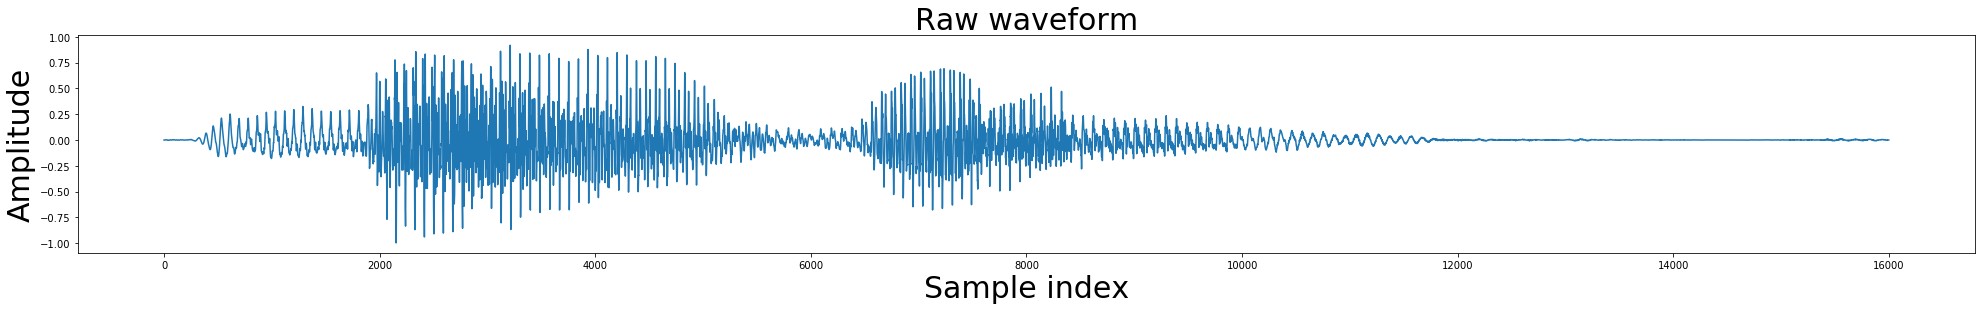

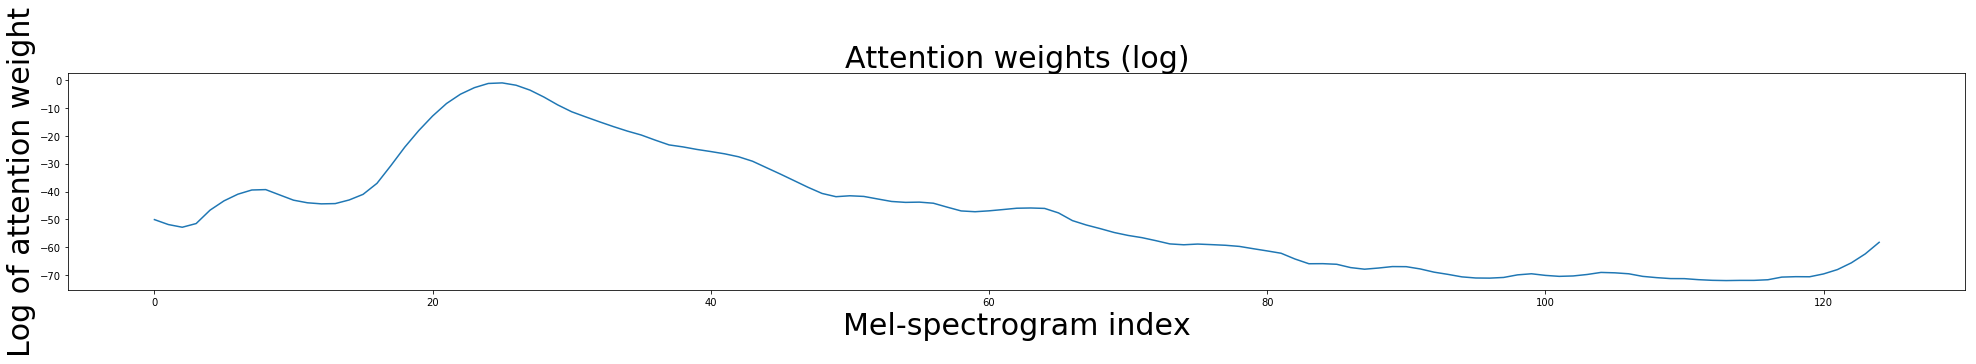

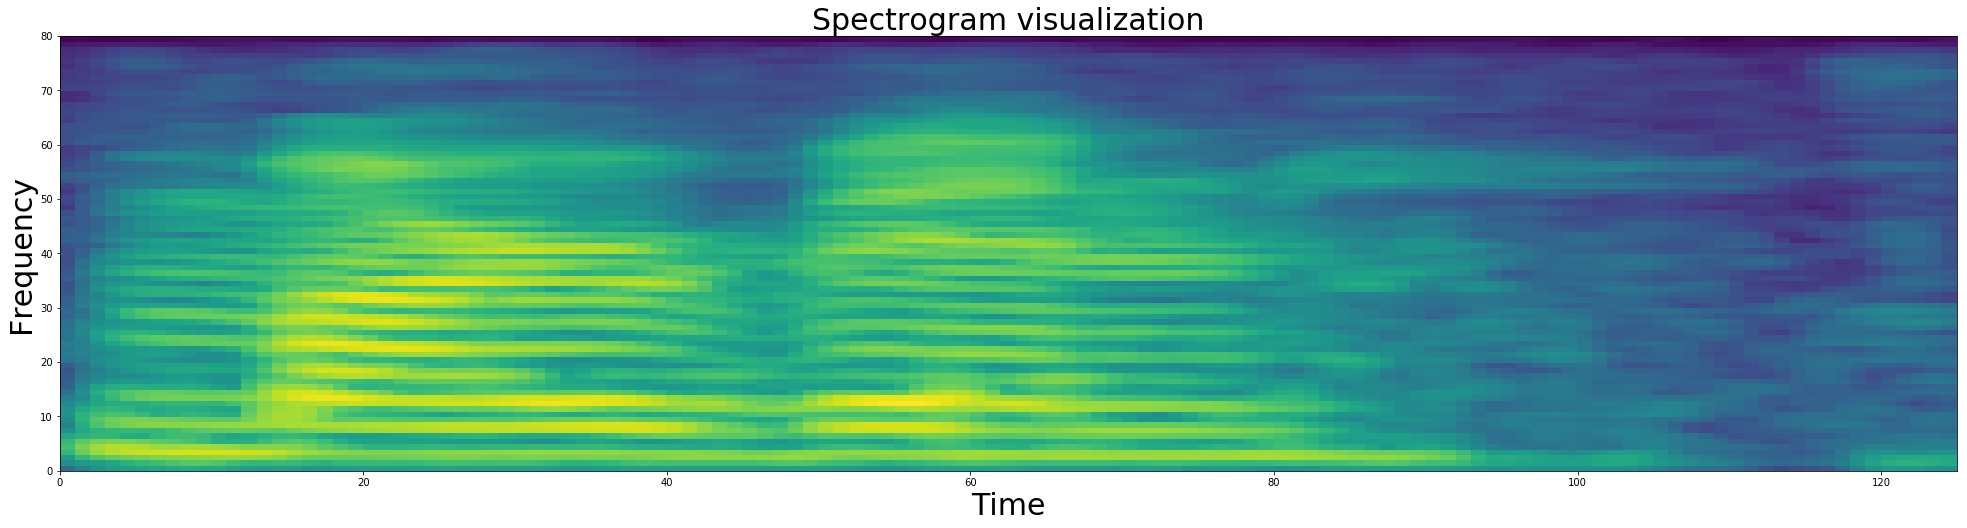

In [0]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [0]:
y_pred = model.predict(x_test, verbose=1)

6835/6835 [==============================] - 10s 1ms/step


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [0]:
set(y_test)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 28,
 29,
 31,
 32,
 33,
 35}

In [0]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [0]:
#35word, v1
classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
         'marvin', 'sheila', 'tree', 'wow']

In [0]:
#20cmd
classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Normalized confusion matrix


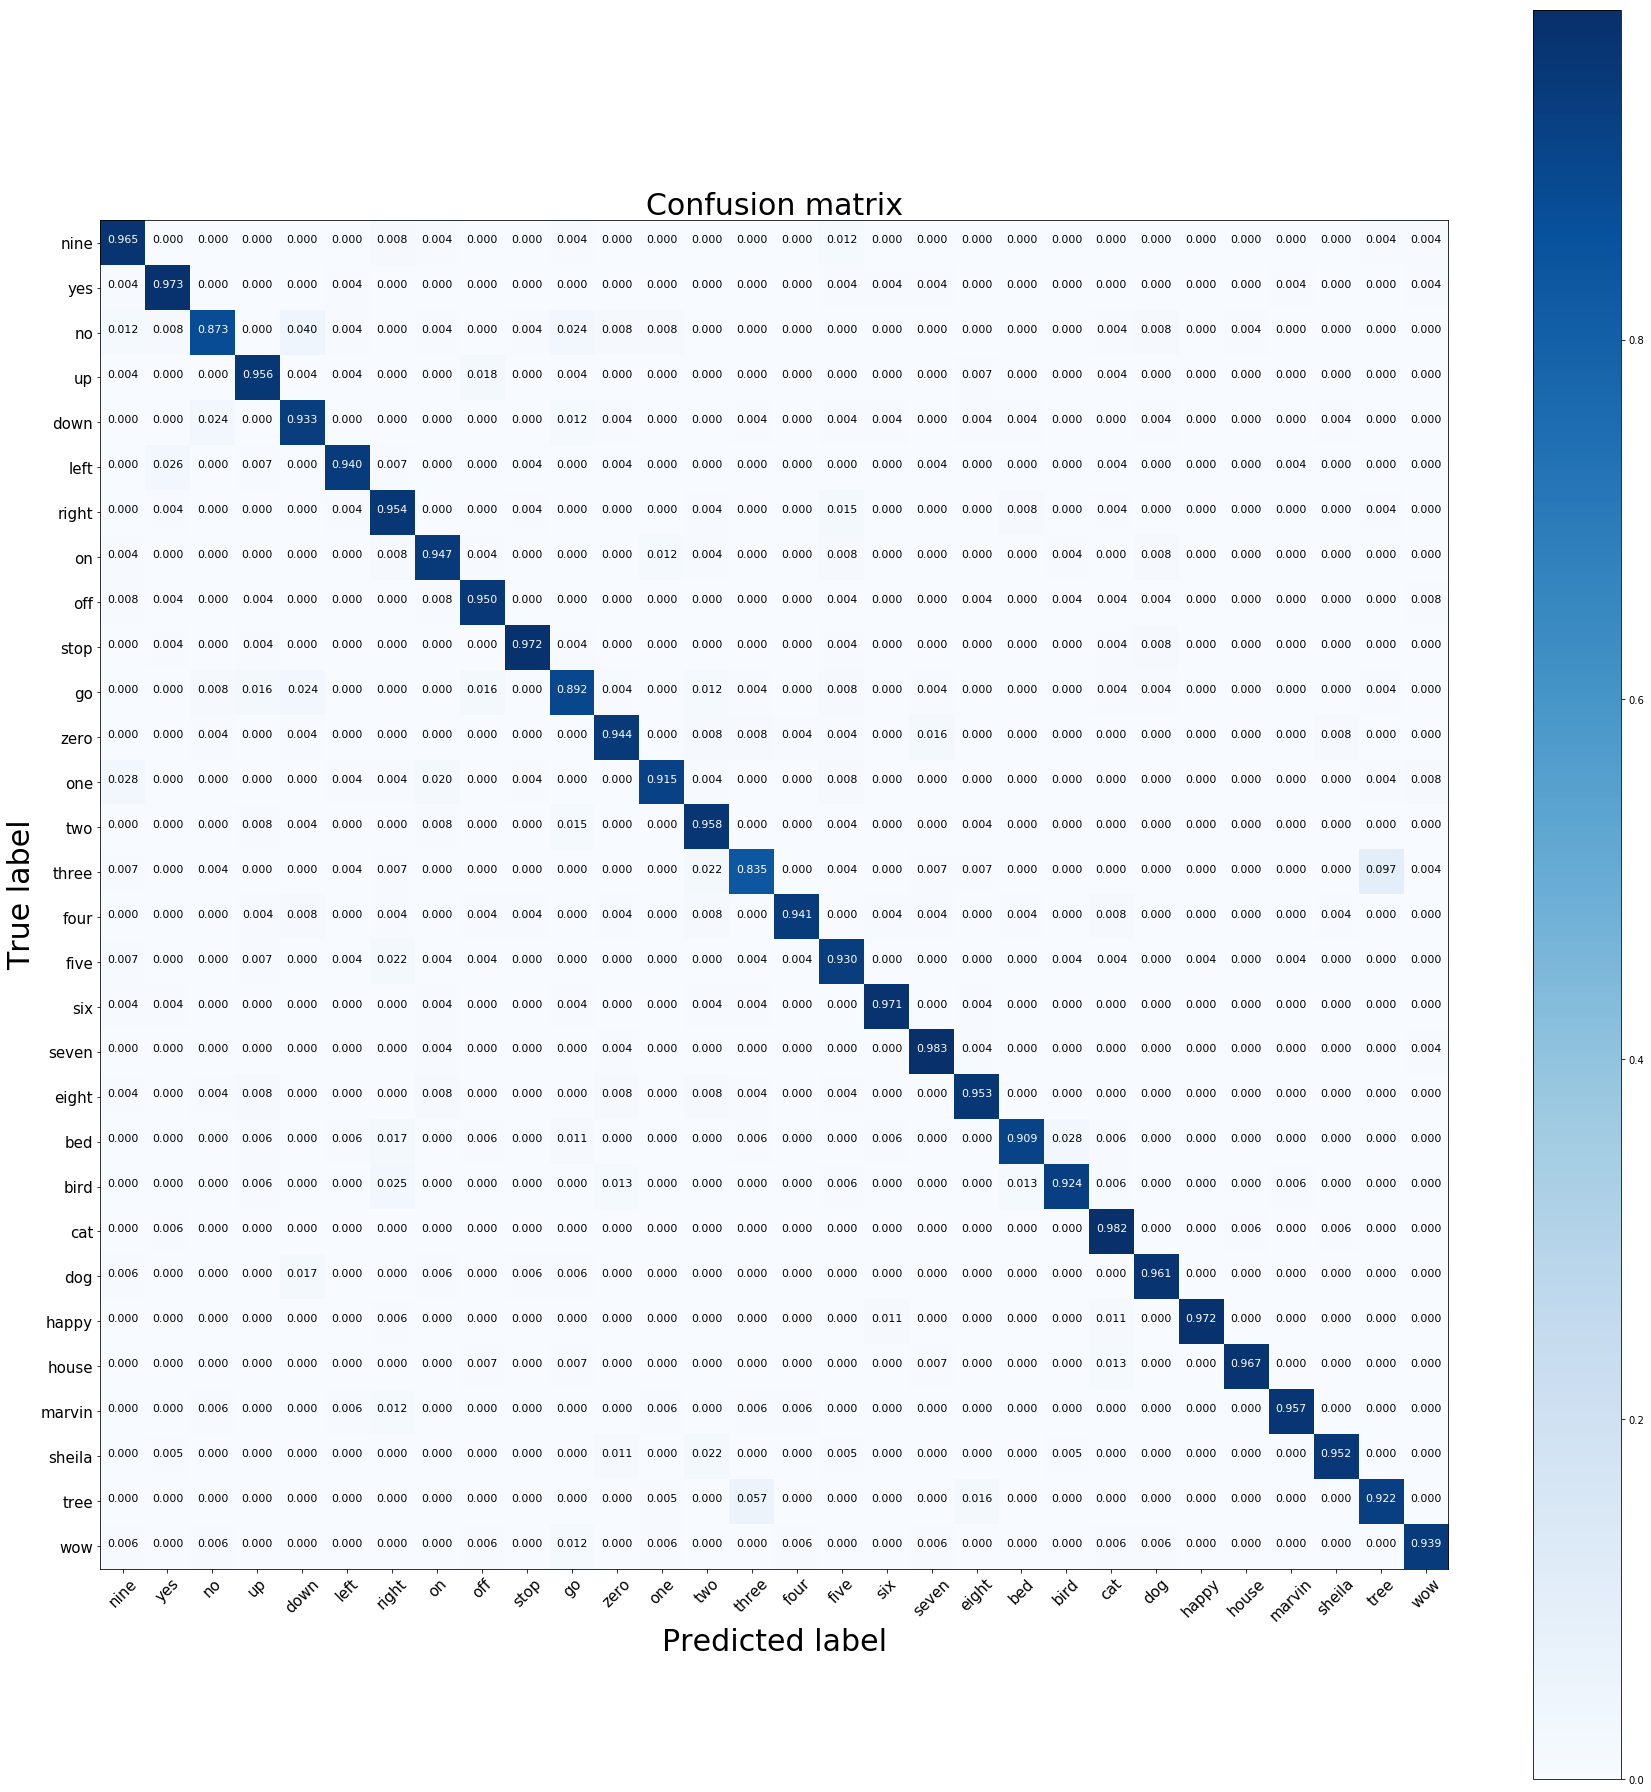

In [0]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=True)